<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/training-loop/notebooks/TransGAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Check GPU
!nvidia-smi

Thu Apr  8 20:30:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

DC GAN adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Calculates FID score in PyTorch

In [2]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torchsummary import summary
from types import SimpleNamespace

In [3]:
!git clone --single-branch --branch training-loop https://github.com/azfarkhoja305/GANs.git

Cloning into 'GANs'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 301 (delta 162), reused 174 (delta 78), pack-reused 0
Receiving objects: 100% (301/301), 105.30 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (162/162), done.


In [4]:
Path.ls = lambda x: list(x.iterdir())
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [5]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [6]:
from google.colab import drive
drive.mount('/content/drive')
gdrive = Path('drive/MyDrive')

# Create a required checkpoint instance. 
# If does not exists, Checkpoint class will create one.
ckp_folder = gdrive/'temporary_checkpoint'

Mounted at /content/drive


In [7]:
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [8]:
!PYTHONPATH=./GANs python ./GANs/scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
170499072it [00:02, 67306161.74it/s]                   
Extracting data/cifar_10/cifar-10-python.tar.gz to data/cifar_10
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 98.1MB/s]


# Training

In [9]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999
num_epochs = 20

Files already downloaded and verified


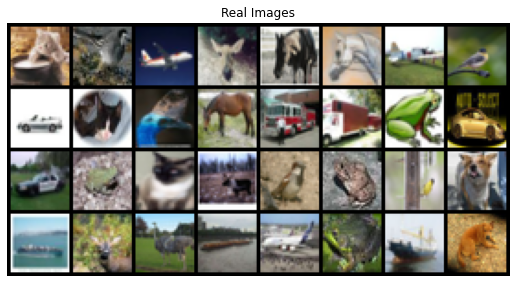

In [10]:
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, num_workers=2)
display_images(dataset.train_loader)

In [11]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

In [12]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
# summary(Dis,(3,32,32,))

In [13]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [14]:
img_list = []
G_losses = []
D_losses = []
loss_logs = {'gen_loss': [], 'dis_loss': []}
iters = 0

In [15]:
ckp_class = Checkpoint(ckp_folder, max_epochs=num_epochs, num_ckps=5, start_after=0.1)

# check if any existing checkpoint exists, none found hence start_epoch is 0.
# Optimizer states also get saved
Gen, Dis, optG, optD, start_epoch, old_logs = \
                        ckp_class.check_if_exists(Gen, Dis, optG, optD)

loss_logs = old_logs or loss_logs
start_epoch #, loss_logs

Checkpoint folder with checkpoints already exists. Searching for the latest.
=> Loading checkpoint: drive/MyDrive/temporary_checkpoint/GanModel_6.pth


7

In [16]:
for epoch in range(start_epoch, num_epochs + 1):
    for i, data in enumerate(dataset.train_loader):
        
        ###########################
        # (1) Update Dis network
        ###########################
        
        ## Train with all-real batch
        Dis.zero_grad()
        real = data[0].to(device)
        output_real = Dis(real).view(-1)

        ## Train with all-fake batch
        dis_z = torch.randn(dis_batch_sz, latent_dims, device=device)
        fake_1 = Gen(dis_z).detach()
        output_fake_1 = Dis(fake_1).view(-1)

        ## Compute loss and backpropagate
        errD = wgangp_eps_loss(Dis, real, fake_1, 1.0, output_real, output_fake_1)
        errD.backward()
        torch.nn.utils.clip_grad_norm_(Dis.parameters(), 5.0)
        optD.step()

        ###########################
        # (2) Update Gen network
        ###########################
        
        Gen.zero_grad()
        gen_z = torch.randn(gen_batch_sz, latent_dims, device=device)
        fake_2 = Gen(gen_z)
        output_fake_2 = Dis(fake_2).view(-1)
        errG = -torch.mean(output_fake_2)
        errG.backward()
        torch.nn.utils.clip_grad_norm_(Gen.parameters(), 5.0)
        optG.step()

        ###########################
        # (3) Output
        ###########################

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if (i+1) %100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                % (epoch, num_epochs, i, len(dataset.train_loader),
                     errD.item(), errG.item()))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataset.train_loader)-1)):
            with torch.no_grad():
                fixed_fake = Gen(fixed_z).detach().cpu()
            img_list.append(vutils.make_grid(fixed_fake, padding=2, normalize=True))

        iters +=1
    
    
    loss_logs['gen_loss'].append(errG.item()) #TODO: mean loss per epoch
    loss_logs['dis_loss'].append(errD.item())

    # Checkpoint
    ckp_class.at_epoch_end(Gen, Dis, optG, optD, epoch=epoch, loss_logs=loss_logs)

[7/20][99/1562]	Loss_D: -0.6188	Loss_G: 0.5037


KeyboardInterrupt: ignored

# Analysis

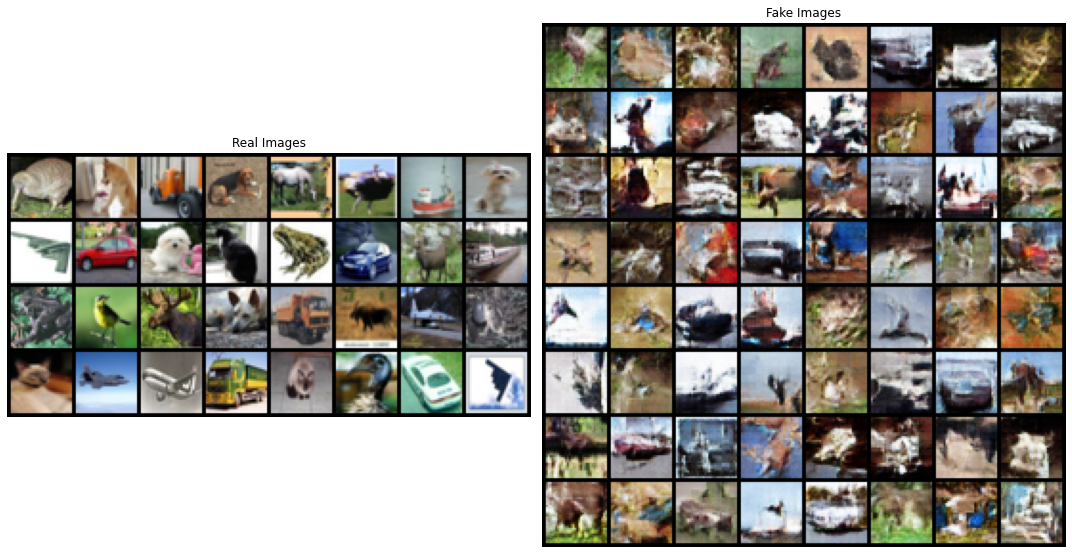

In [17]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0])
display_images(img_list, ax = axs[1])
plt.tight_layout()

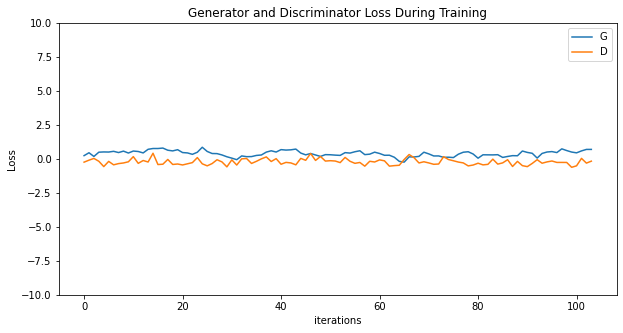

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.ylim([-10,10])
plt.legend()
plt.show()

Calculating FID Score

In [19]:
from metrics.torch_is_fid_score import is_fid_from_generator
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
inception_score, fid = is_fid_from_generator(generator=Gen,
                                        latent_dims=latent_dims,
                                        num_imgs=10000,
                                        batch_sz=256,
                                        fid_stat_path = stat_path)

In [20]:
print(f"\nFID score: {fid}")
print(f"\nIS: {inception_score}")


FID score: 85.34259033203125

IS: (4.988857746124268, 0.1348227709531784)


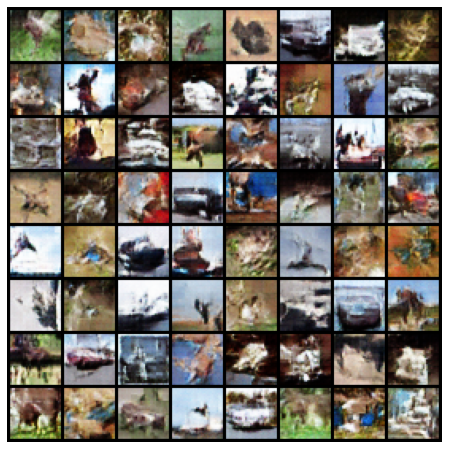

In [21]:
rc('animation', html='jshtml')
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani